Dr. Tobias Gensch, 2022

Gensch, T.; Smith, S.; Colacot, T.; Timsina, Y.; Xu, G.; Glasspoole, B.; Sigman, M.

Design and Application of a Screening Set for Monophosphine Ligands in Cross-Coupling

ACS Catalysis, 2022

https://doi.org/10.1021/acscatal.2c01970


# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from sklearn.cluster import KMeans

from rdkit import Chem,Geometry
from rdkit.Chem import rdmolfiles, AllChem, rdMolAlign,rdmolops, Descriptors, Draw, PandasTools

from collections import Counter

%matplotlib inline

import random

from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from rdkit.Chem import rdFingerprintGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances_argmin_min


from rdkit import RDLogger                                                                                                                                                               
from rdkit.Chem.Draw import rdMolDraw2D
import seaborn as sns
try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO
from scipy.linalg import qr

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics import silhouette_score
#import plotly.express as px

from IPython.display import HTML
from rdkit.Chem import rdDepictor
from IPython.display import SVG

from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.resources import INLINE 
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.models import Legend, LegendItem
from bokeh.palettes import RdBu3,RdBu9,Spectral6
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
import openpyxl

In [2]:
#defining the 32 colors for the 32 clusters that will be created later in the notebook
colors32 = ['#000000', '#222034', '#45283c', '#663931', '#8f563b', '#df7126', '#d9a066', '#eec39a', '#fbf236', '#99e550', '#6abe30', '#37946e', '#4b692f', '#524b24', '#323c39', '#3f3f74', '#306082', '#5b6ee1', '#639bff', '#5fcde4', '#cbdbfc', '#dddddd', '#9badb7', '#847e87', '#696a6a', '#595652', '#76428a', '#ac3232', '#d95763', '#d77bba', '#8f974a', '#8a6f30']

#defining a function that allows one to convert smiles to structures. Will be used later in the notebook
def mol_to_img_df(row):
    mol = Chem.MolFromSmiles(row["smiles"])
    return(Draw.MolToImage(mol))

#defining the function that allows to find the ligand that is closest to the cluster center. WIll be used in the context of kmeans clustering
def dist_to_center(line):
    delta = line[use_cols] - kmeans.cluster_centers_[line["cluster"]]
    dist = np.linalg.norm(delta)
    return(dist)

# Read Data

In [3]:
#read the excel shreadsheet containing all the DFT features of the selected arylbromides (no filtering using notebook 1 performed)
all_features = pd.read_csv("combined.csv")

print("all_Features")
print(all_features.shape)
display(all_features)

all_Features
(13, 229)


,id,smiles,%Vbur_C1_2.0Å_Boltz,%Vbur_C1_2.0Å_Vbur_min,%Vbur_C1_2.0Å_low_E,%Vbur_C1_2.0Å_max,%Vbur_C1_2.0Å_min,%Vbur_C1_2.5Å_Boltz,%Vbur_C1_2.5Å_Vbur_min,%Vbur_C1_2.5Å_low_E,...,μ_Boltz,μ_Vbur_min,μ_low_E,μ_max,μ_min,ω_Boltz,ω_Vbur_min,ω_low_E,ω_max,ω_min
0,pyrd1,BrC1=C2C(OCCC2)=CN=C1,90.705708,90.705708,90.705708,90.705708,90.705708,74.778617,74.778617,74.778617,...,-0.148205,-0.148205,-0.148205,-0.148205,-0.148205,0.038490,0.03849,0.03849,0.03849,0.03849
1,pyrd2,ClC1=NC=CC=C1C,95.180139,95.180139,95.180139,95.180139,95.180139,85.671962,85.671962,85.671962,...,-0.158740,-0.158740,-0.158740,-0.158740,-0.158740,0.041650,0.04165,0.04165,0.04165,0.04165
2,pyrd3,BrC1=CC(C)=NC=C1,95.716038,95.716038,95.716038,95.716038,95.716038,85.748470,85.748470,85.748470,...,-0.166500,-0.166500,-0.166500,-0.166500,-0.166500,0.044680,0.04468,0.04468,0.04468,0.04468
3,pyrd4,O=C(NC1=NC=CC(C2CC2)=C1)C3=CC=C(B4OC(C)(C)C(C)...,94.741043,94.731405,94.731405,94.976756,94.731405,84.651442,84.703412,84.703412,...,-0.158143,-0.158135,-0.158135,-0.157120,-0.158165,0.049803,0.04981,0.04981,0.04981,0.04817
4,pyrd5,ClC1=NC(C(F)(F)F)=CC(C)=C1,95.276989,95.276989,95.276989,95.276989,95.276989,85.032231,85.032231,85.032231,...,-0.182130,-0.182130,-0.182130,-0.182130,-0.182130,0.054590,0.05459,0.05459,0.05459,0.05459
5,pyrd6,BrC1=CC(C)=CC(NC(OC(C)(C)C)=O)=N1,95.147784,94.957386,95.154313,95.154313,94.724948,85.525035,85.614989,85.540109,...,-0.146721,-0.153625,-0.146690,-0.146690,-0.153625,0.037900,0.04167,0.03788,0.04167,0.03788
6,pyrd7,FC(F)(C1=CC(C(F)(F)F)=CC(C2=CN=CC(C)=C2)=C1)F,90.977815,91.002712,91.002712,91.002712,90.951059,75.694937,75.712983,75.712983,...,-0.177107,-0.177020,-0.177020,-0.177020,-0.177200,0.058653,0.05861,0.05861,0.05870,0.05861
7,pyrd8,BrC1=NC(C2=CN=CS2)=CC(C)=C1,95.543657,95.858084,95.858084,95.858084,95.228564,86.068125,86.637257,86.637257,...,-0.165790,-0.165875,-0.165875,-0.165705,-0.165875,0.056160,0.05610,0.05610,0.05622,0.05610
8,pyrd9,CC1=NC(Cl)=CC2=C1C=NN2,95.699897,95.699897,95.699897,95.699897,95.699897,85.989387,85.989387,85.989387,...,-0.159125,-0.159125,-0.159125,-0.159125,-0.159125,0.047360,0.04736,0.04736,0.04736,0.04736
9,pyrd10,BrCCCC1=CN=CC=C1,90.734536,91.160899,90.902634,92.252066,90.625000,74.209673,77.646829,76.258302,...,-0.158102,-0.160415,-0.157100,-0.148095,-0.162225,0.040361,0.04143,0.03981,0.04286,0.03604


In [4]:
def draw_grid_image(img_list, title_list, num_cols, item_prefix, save_image_prefix):
    num_images = len(img_list)
    num_rows = (
        num_images + num_cols - 1
    ) // num_cols  # Calculate number of rows needed

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_list[i])
        plt.axis("on")  # Turn on the axis to show grid lines
        plt.grid(True)  # Enable grid lines
        plt.title(title_list[i], fontsize=20)
        plt.xticks([])  # Remove x-ticks
        plt.yticks([])  # Remove y-ticks

    # Adjust layout to make sure everything fits and display the grid
    plt.tight_layout()
    # save the grid image to a file
    if save_image_prefix is not None:
        plt.savefig(save_image_prefix + item_prefix + ".png")
    # don't display the image in the notebook
    plt.show()

pyrd


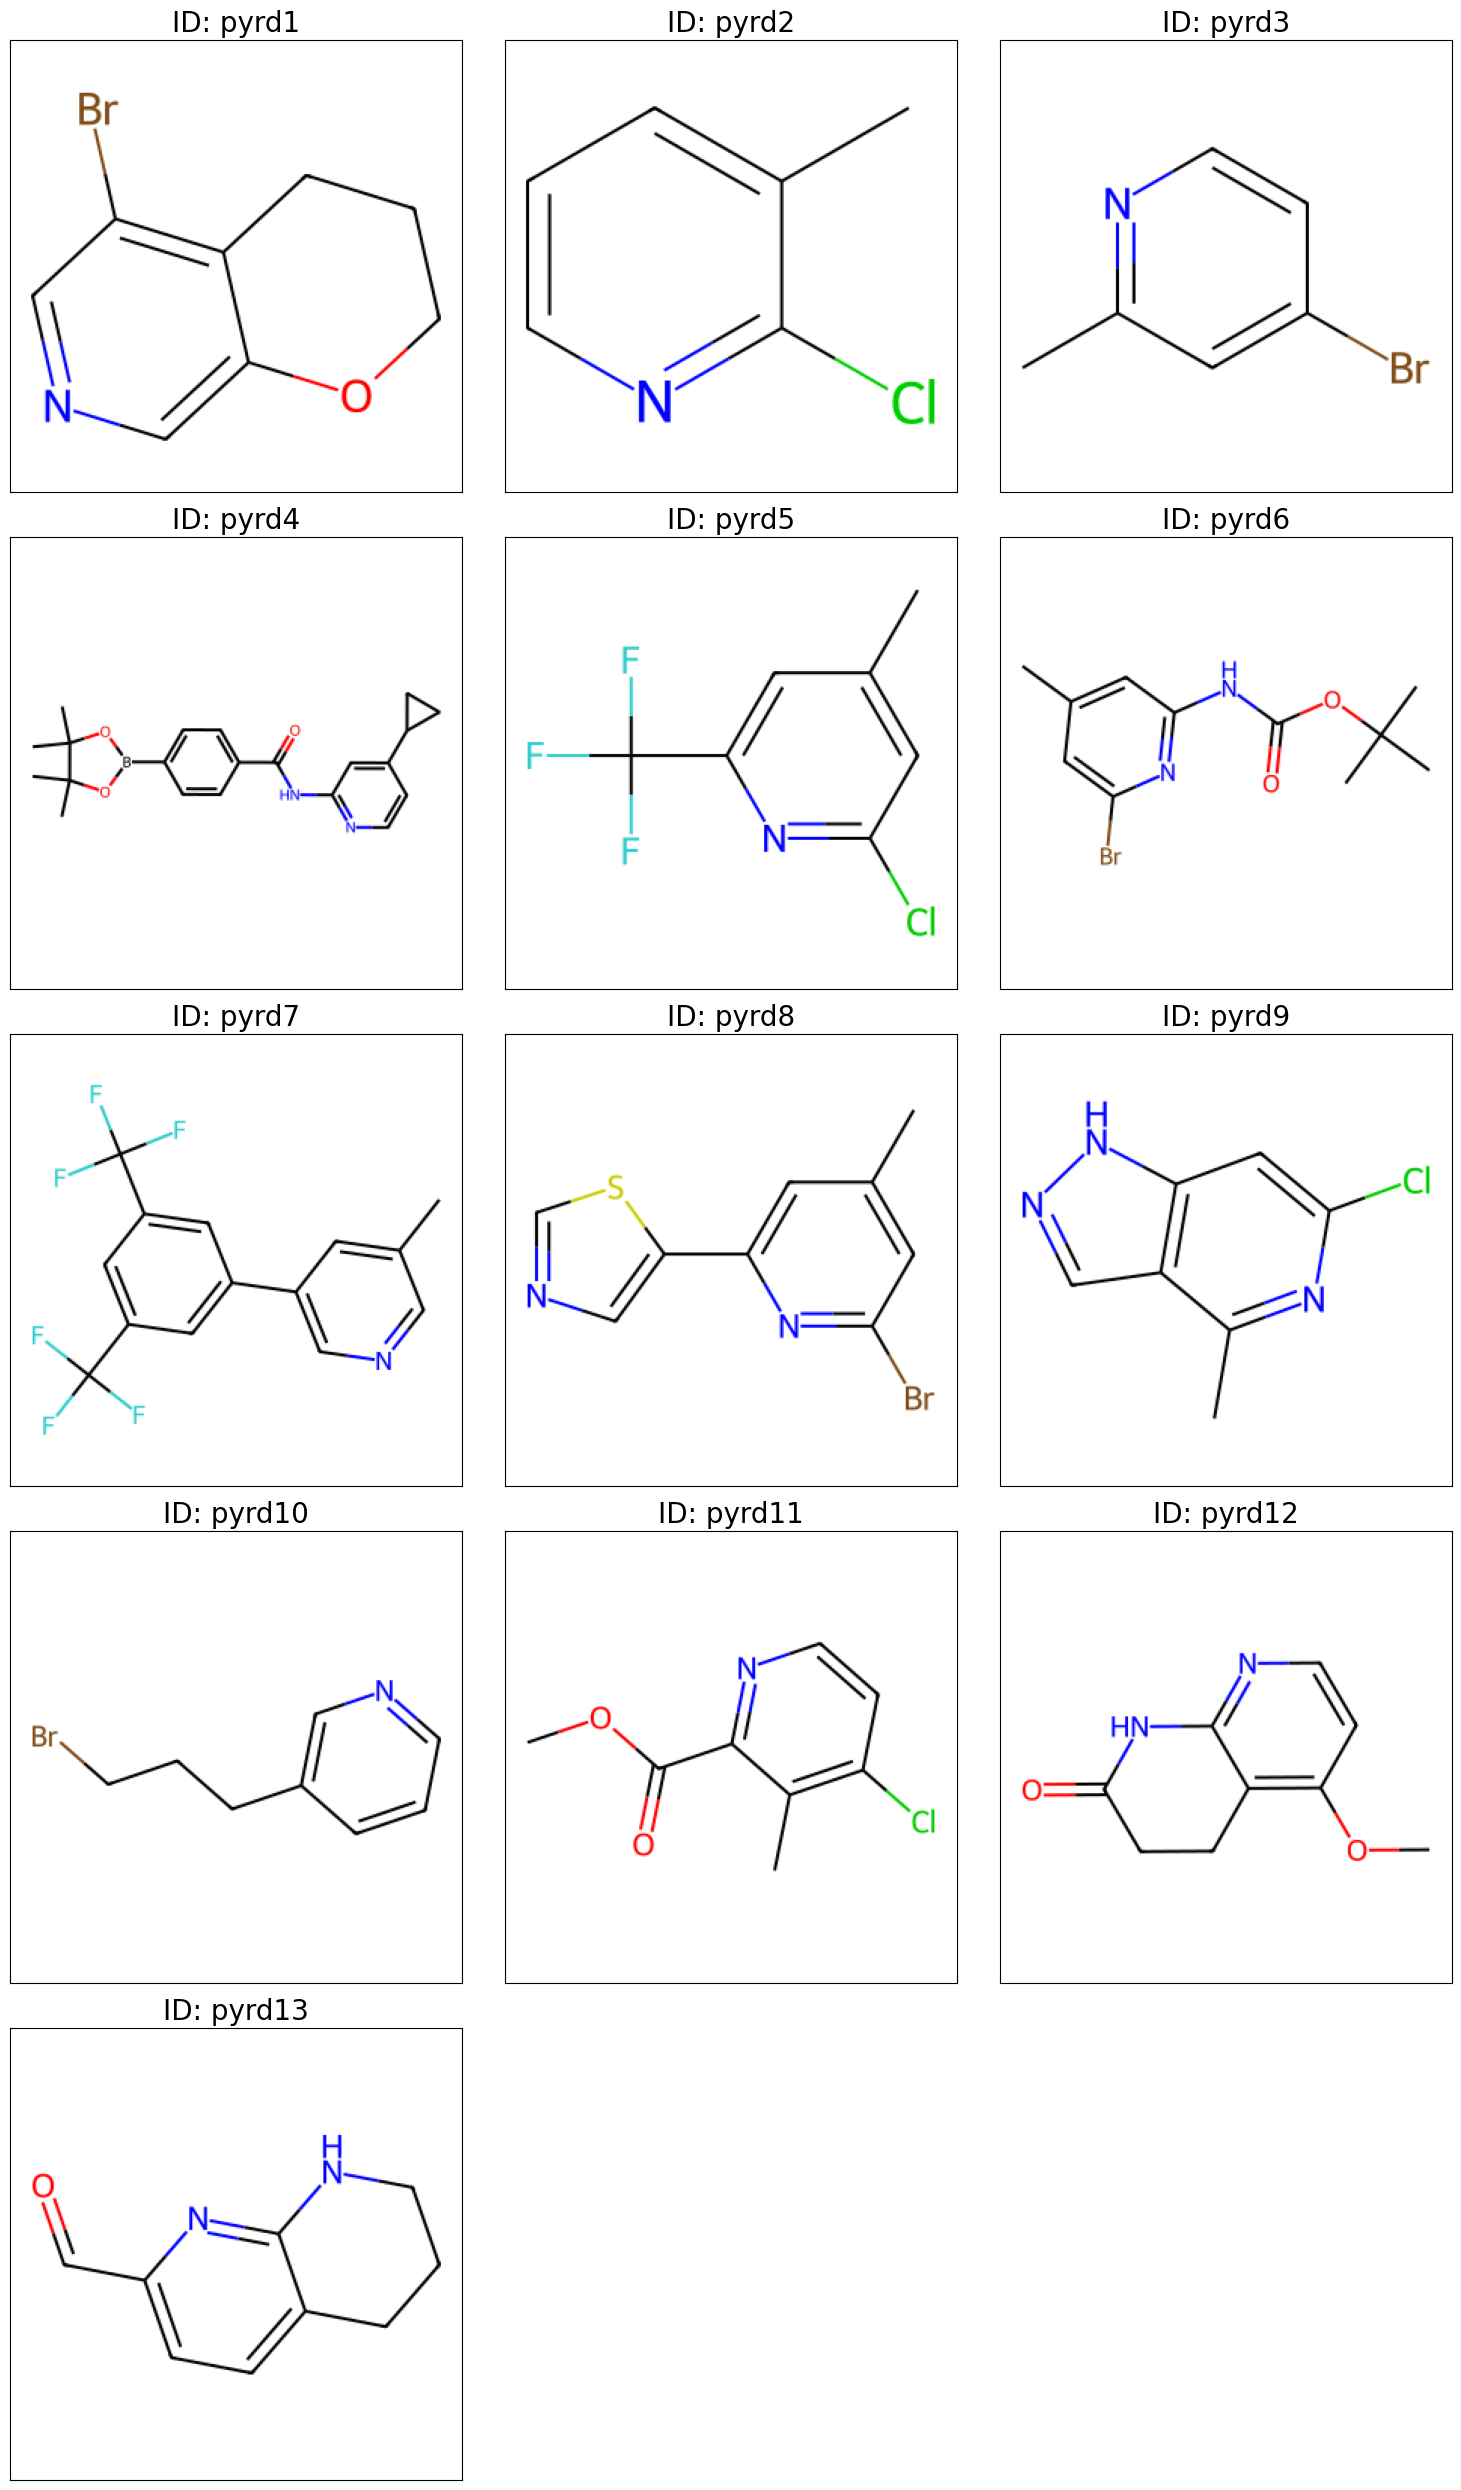

In [5]:
# group all rows based on the common prefix of the molecule id (which is a alphanumeric string), then extract only the id and smiles columns
all_features_grouped = all_features.groupby(all_features["id"].str.extract(r'(\D+)')[0])[["id","smiles"]]
for name, group in all_features_grouped:
    print(name)
    # now based on the smiles column, plot the structures of each group in a grid with 3 columns using
    legends = [f"ID: {i}" for i in group["id"]]
    mols_img = [Chem.Draw.MolToImage(Chem.MolFromSmiles(smiles)) for smiles in group["smiles"]]
    draw_grid_image(mols_img, legends, 3, name, f"{name}_grid_image_")

In [6]:
#drop the smiles and ID columns from the all_features dataframe shown above.
all_features_nosmiles = all_features.drop(['smiles', 'id', ], axis=1)
print(all_features_nosmiles.shape)
display(all_features_nosmiles)

(13, 227)


,%Vbur_C1_2.0Å_Boltz,%Vbur_C1_2.0Å_Vbur_min,%Vbur_C1_2.0Å_low_E,%Vbur_C1_2.0Å_max,%Vbur_C1_2.0Å_min,%Vbur_C1_2.5Å_Boltz,%Vbur_C1_2.5Å_Vbur_min,%Vbur_C1_2.5Å_low_E,%Vbur_C1_2.5Å_max,%Vbur_C1_2.5Å_min,...,μ_Boltz,μ_Vbur_min,μ_low_E,μ_max,μ_min,ω_Boltz,ω_Vbur_min,ω_low_E,ω_max,ω_min
0,90.705708,90.705708,90.705708,90.705708,90.705708,74.778617,74.778617,74.778617,74.778617,74.778617,...,-0.148205,-0.148205,-0.148205,-0.148205,-0.148205,0.038490,0.03849,0.03849,0.03849,0.03849
1,95.180139,95.180139,95.180139,95.180139,95.180139,85.671962,85.671962,85.671962,85.671962,85.671962,...,-0.158740,-0.158740,-0.158740,-0.158740,-0.158740,0.041650,0.04165,0.04165,0.04165,0.04165
2,95.716038,95.716038,95.716038,95.716038,95.716038,85.748470,85.748470,85.748470,85.748470,85.748470,...,-0.166500,-0.166500,-0.166500,-0.166500,-0.166500,0.044680,0.04468,0.04468,0.04468,0.04468
3,94.741043,94.731405,94.731405,94.976756,94.731405,84.651442,84.703412,84.703412,85.382211,84.612254,...,-0.158143,-0.158135,-0.158135,-0.157120,-0.158165,0.049803,0.04981,0.04981,0.04981,0.04817
4,95.276989,95.276989,95.276989,95.276989,95.276989,85.032231,85.032231,85.032231,85.032231,85.032231,...,-0.182130,-0.182130,-0.182130,-0.182130,-0.182130,0.054590,0.05459,0.05459,0.05459,0.05459
5,95.147784,94.957386,95.154313,95.154313,94.724948,85.525035,85.614989,85.540109,85.614989,84.548769,...,-0.146721,-0.153625,-0.146690,-0.146690,-0.153625,0.037900,0.04167,0.03788,0.04167,0.03788
6,90.977815,91.002712,91.002712,91.002712,90.951059,75.694937,75.712983,75.712983,75.712983,75.675544,...,-0.177107,-0.177020,-0.177020,-0.177020,-0.177200,0.058653,0.05861,0.05861,0.05870,0.05861
7,95.543657,95.858084,95.858084,95.858084,95.228564,86.068125,86.637257,86.637257,86.637257,85.497786,...,-0.165790,-0.165875,-0.165875,-0.165705,-0.165875,0.056160,0.05610,0.05610,0.05622,0.05610
8,95.699897,95.699897,95.699897,95.699897,95.699897,85.989387,85.989387,85.989387,85.989387,85.989387,...,-0.159125,-0.159125,-0.159125,-0.159125,-0.159125,0.047360,0.04736,0.04736,0.04736,0.04736
9,90.734536,91.160899,90.902634,92.252066,90.625000,74.209673,77.646829,76.258302,80.020185,73.694491,...,-0.158102,-0.160415,-0.157100,-0.148095,-0.162225,0.040361,0.04143,0.03981,0.04286,0.03604


In [7]:
#scaling features in the data table 'all_features_nosmiles'
scaler = StandardScaler()
scaler.fit(all_features_nosmiles)
all_features_nosmiles_scaled = pd.DataFrame(scaler.transform(all_features_nosmiles), columns=all_features_nosmiles.columns)
all_features_nosmiles_scaled

,%Vbur_C1_2.0Å_Boltz,%Vbur_C1_2.0Å_Vbur_min,%Vbur_C1_2.0Å_low_E,%Vbur_C1_2.0Å_max,%Vbur_C1_2.0Å_min,%Vbur_C1_2.5Å_Boltz,%Vbur_C1_2.5Å_Vbur_min,%Vbur_C1_2.5Å_low_E,%Vbur_C1_2.5Å_max,%Vbur_C1_2.5Å_min,...,μ_Boltz,μ_Vbur_min,μ_low_E,μ_max,μ_min,ω_Boltz,ω_Vbur_min,ω_low_E,ω_max,ω_min
0,-1.853126,-1.922455,-1.878656,-2.112284,-1.505462,-1.838533,-2.094250,-1.990132,-2.257083,-1.424780,...,1.024755,1.128280,1.016283,0.927868,1.140137,-1.097863,-1.203204,-1.086536,-1.230173,-0.992178
1,0.516224,0.492408,0.484319,0.455982,0.686491,0.575263,0.537242,0.543430,0.504233,0.743356,...,0.176954,0.244884,0.171047,0.086555,0.257649,-0.678524,-0.763769,-0.669660,-0.787345,-0.576019
2,0.799999,0.781634,0.767331,0.763581,0.949019,0.592216,0.555724,0.561224,0.523627,0.758584,...,-0.447531,-0.405818,-0.451548,-0.533150,-0.392385,-0.276436,-0.342412,-0.269934,-0.362735,-0.176979
3,0.283709,0.250225,0.247340,0.339243,0.466663,0.349132,0.303271,0.318166,0.430785,0.532439,...,0.224996,0.295616,0.219587,0.215926,0.305815,0.403423,0.370974,0.406829,0.356159,0.282640
4,0.567509,0.544678,0.535466,0.511572,0.733936,0.433509,0.382703,0.394642,0.342070,0.616028,...,-1.705351,-1.716448,-1.705562,-1.781344,-1.701668,1.038643,1.035688,1.037420,1.026007,1.128129
5,0.499091,0.372188,0.470680,0.441158,0.463500,0.542707,0.523479,0.512764,0.489791,0.519803,...,1.144196,0.673795,1.137833,1.048854,0.686119,-1.176147,-0.760988,-1.167008,-0.784543,-1.072513
6,-1.709036,-1.762161,-1.721806,-1.941808,-1.385269,-1.635491,-1.868536,-1.772818,-2.020234,-1.246262,...,-1.301107,-1.287957,-1.295580,-1.373265,-1.288695,1.577862,1.594716,1.567749,1.601963,1.657548
7,0.708718,0.858296,0.842346,0.845113,0.710213,0.663047,0.770427,0.767938,0.748922,0.708689,...,-0.390401,-0.353410,-0.401403,-0.469662,-0.340031,1.246977,1.245671,1.236623,1.254427,1.326990
8,0.791451,0.772922,0.758807,0.754316,0.941112,0.645600,0.613922,0.617257,0.584696,0.806534,...,0.145971,0.212601,0.140158,0.055809,0.225398,0.079206,0.030273,0.083619,0.012828,0.175966
9,-1.837860,-1.676787,-1.774658,-1.224694,-1.545000,-1.964602,-1.401379,-1.645988,-0.928416,-1.640557,...,0.228258,0.104430,0.302626,0.936652,-0.034280,-0.849538,-0.794363,-0.912398,-0.617781,-1.314834


In [8]:
#Colinearity analysis: dropping highly correlated variables
threshold = 0.95 
print(f'Shape of descriptors file before removing parameters with R^2 > {threshold} :',all_features_nosmiles_scaled.shape)
df_corr = all_features_nosmiles_scaled.corr()
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == False].index
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
all_features_nosmiles_scaled = all_features_nosmiles_scaled[un_corr_idx]
print(f'Shape of descriptors file after removing parameters with R^2 > {threshold} : ',all_features_nosmiles_scaled.shape)

Shape of descriptors file before removing parameters with R^2 > 0.95 : (13, 227)
Shape of descriptors file after removing parameters with R^2 > 0.95 :  (13, 62)


In [9]:
#Find desriptors that are correlated. Enter desired feature
feature = 'HOMO_Boltz'

#Set R^2 vlaue here
corr_features = df_corr[feature].loc[abs(df_corr[feature]) > 0.95]
print(corr_features)

HOMO_Boltz       1.000000
HOMO_Vbur_min    0.995464
HOMO_low_E       0.999917
HOMO_max         0.983800
HOMO_min         0.995514
Name: HOMO_Boltz, dtype: float64


In [10]:
display(corr_idx)
print(len(corr_idx))

Index(['%Vbur_C1_2.0Å_Vbur_min', '%Vbur_C1_2.0Å_low_E', '%Vbur_C1_2.0Å_max',
       '%Vbur_C1_2.5Å_Boltz', '%Vbur_C1_2.5Å_Vbur_min', '%Vbur_C1_2.5Å_low_E',
       '%Vbur_C1_2.5Å_max', '%Vbur_C1_2.5Å_min', '%Vbur_C1_3.0Å_Boltz',
       '%Vbur_C1_3.0Å_Vbur_min',
       ...
       'η_min', 'μ_Vbur_min', 'μ_low_E', 'μ_max', 'μ_min', 'ω_Boltz',
       'ω_Vbur_min', 'ω_low_E', 'ω_max', 'ω_min'],
      dtype='object', length=165)

165


<Axes: >

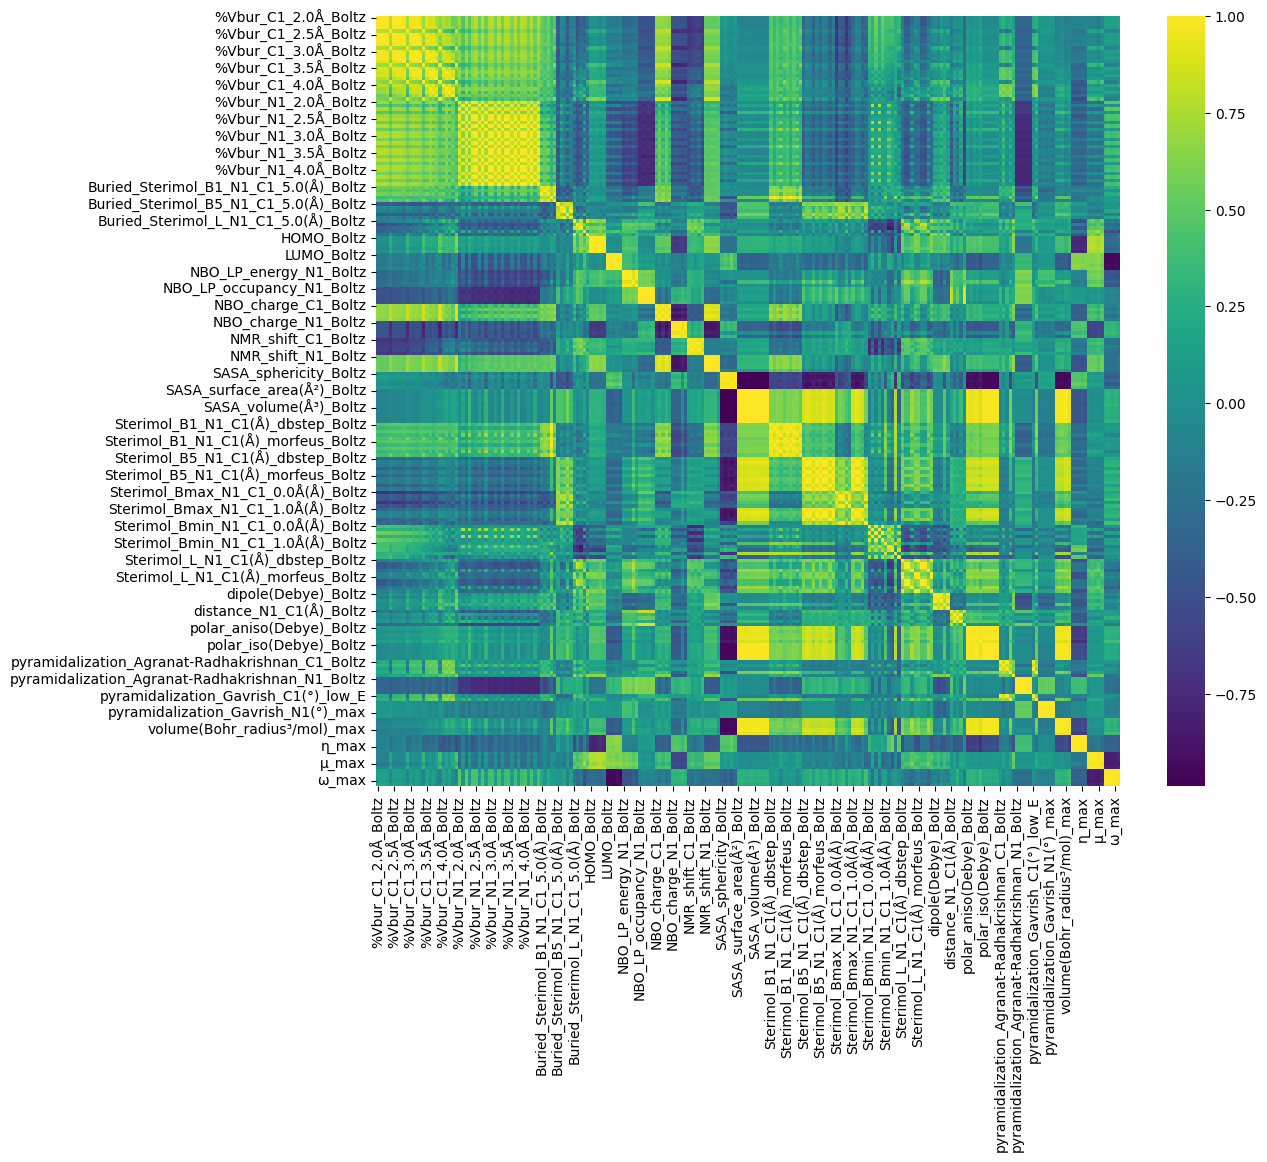

In [11]:
plt.subplots(figsize=(12,10))
sns.heatmap(df_corr,cmap='viridis')

In [12]:
all_features_nosmiles_scaled

,%Vbur_C1_2.0Å_Boltz,%Vbur_C1_2.0Å_min,%Vbur_N1_2.0Å_Boltz,%Vbur_N1_2.0Å_Vbur_min,Buried_Sterimol_B1_N1_C1_5.0(Å)_Boltz,Buried_Sterimol_B1_N1_C1_5.0(Å)_Vbur_min,Buried_Sterimol_B1_N1_C1_5.0(Å)_max,Buried_Sterimol_B1_N1_C1_5.0(Å)_min,Buried_Sterimol_B5_N1_C1_5.0(Å)_Boltz,Buried_Sterimol_B5_N1_C1_5.0(Å)_Vbur_min,...,distance_N1_C1(Å)_min,polar_aniso(Debye)_Boltz,pyramidalization_Agranat-Radhakrishnan_C1_Boltz,pyramidalization_Agranat-Radhakrishnan_C1_Vbur_min,pyramidalization_Agranat-Radhakrishnan_C1_max,pyramidalization_Agranat-Radhakrishnan_C1_min,pyramidalization_Agranat-Radhakrishnan_N1_Boltz,pyramidalization_Gavrish_N1(°)_Boltz,η_Boltz,μ_Boltz
0,-1.853126,-1.505462,-1.061982,-0.777129,-1.175084,-1.526325,-1.248999,-1.004178,0.295608,0.325142,...,0.183055,-0.571167,-0.569883,-0.631605,-0.795852,-0.423638,0.666430,-0.011476,0.211707,1.024755
1,0.516224,0.686491,-0.380996,-0.416838,-0.004122,-0.266458,-0.368485,0.116132,-1.930428,-1.555416,...,-1.277225,-0.886378,-0.659333,-0.709214,-0.863835,-0.545400,0.669374,-0.027394,0.906804,0.176954
2,0.799999,0.949019,-0.543004,-0.502552,0.106399,-0.147546,-0.285379,0.221871,0.313483,0.340243,...,1.442599,-0.706850,-0.658573,-0.708555,-0.863257,-0.544365,0.669374,-0.078244,1.219335,-0.447531
3,0.283709,0.466663,-0.232457,-0.350010,0.537201,0.443256,2.496906,0.469149,0.713043,0.250528,...,0.290184,2.949963,-0.187188,-0.324565,1.856779,0.058078,0.669029,0.052251,-1.175933,0.224996
4,0.567509,0.733936,0.684419,0.146843,2.075338,1.970884,1.195179,2.105639,-0.330458,-0.203760,...,-1.457160,-0.819508,-0.656958,-0.707154,-0.862030,-0.542167,-1.505370,-0.869171,0.958623,-1.705351
5,0.499091,0.463500,0.537454,3.029171,-0.667844,0.549259,0.201614,-0.518891,-0.141967,1.357107,...,-1.356272,0.416390,-0.401213,1.503243,1.074201,-0.194166,-1.504193,-0.861176,0.156689,1.144196
6,-1.709036,-1.385269,-1.172648,-0.827976,-1.175084,-1.526325,-1.248999,-1.004178,1.717656,1.527942,...,0.810227,0.576247,-0.544688,-0.605615,-0.773085,-0.396306,0.655857,-0.027294,-0.515054,-1.301107
7,0.708718,0.710213,2.411197,0.860161,-0.533967,-0.723371,-0.687819,-0.491633,-0.073492,0.070961,...,-1.576770,0.781588,-0.504017,-0.659807,-0.670871,-0.467884,-1.504747,-0.819386,-1.433104,-0.390401
8,0.791451,0.941112,0.552615,0.077109,-0.229780,-0.509249,-0.538171,-0.099765,-0.251692,-0.137217,...,0.307865,-0.250427,-0.655140,-0.705576,-0.860648,-0.539692,0.669374,3.220383,-0.516991,0.145971
9,-1.837860,-1.545000,-1.264572,-0.864296,-1.134304,0.078731,-0.127235,-1.004178,0.460057,-1.552679,...,0.635492,-0.782844,-0.388173,-0.709214,-0.243555,-0.545400,0.666939,0.012555,1.198552,0.228258


In [13]:
#PCA analysis using 44 features that remained after removing the correlated features
pca = PCA(min(all_features_nosmiles_scaled.shape))
scaler = StandardScaler()

X = all_features_nosmiles_scaled
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

#creating a dataframe that have the columns for the first 4 principal components
df_pca = pd.DataFrame({'PC1': X_pca[:,0], 'PC2': X_pca[:,1], 'PC3': X_pca[:,2], 'PC4': X_pca[:,3]})

#adding the columns corresponding to the first four PC's to the all_features data table
all_features['PC1']=X_pca[:,0]
all_features['PC2']=X_pca[:,1]
all_features['PC3']=X_pca[:,2]
all_features['PC4']=X_pca[:,3]
all_features

,id,smiles,%Vbur_C1_2.0Å_Boltz,%Vbur_C1_2.0Å_Vbur_min,%Vbur_C1_2.0Å_low_E,%Vbur_C1_2.0Å_max,%Vbur_C1_2.0Å_min,%Vbur_C1_2.5Å_Boltz,%Vbur_C1_2.5Å_Vbur_min,%Vbur_C1_2.5Å_low_E,...,μ_min,ω_Boltz,ω_Vbur_min,ω_low_E,ω_max,ω_min,PC1,PC2,PC3,PC4
0,pyrd1,BrC1=C2C(OCCC2)=CN=C1,90.705708,90.705708,90.705708,90.705708,90.705708,74.778617,74.778617,74.778617,...,-0.148205,0.038490,0.03849,0.03849,0.03849,0.03849,4.790350,-3.098232,-2.424191,-1.339439
1,pyrd2,ClC1=NC=CC=C1C,95.180139,95.180139,95.180139,95.180139,95.180139,85.671962,85.671962,85.671962,...,-0.158740,0.041650,0.04165,0.04165,0.04165,0.04165,-2.252942,-1.566213,-3.816638,0.608750
2,pyrd3,BrC1=CC(C)=NC=C1,95.716038,95.716038,95.716038,95.716038,95.716038,85.748470,85.748470,85.748470,...,-0.166500,0.044680,0.04468,0.04468,0.04468,0.04468,-4.618687,-4.625961,4.127308,4.942432
3,pyrd4,O=C(NC1=NC=CC(C2CC2)=C1)C3=CC=C(B4OC(C)(C)C(C)...,94.741043,94.731405,94.731405,94.976756,94.731405,84.651442,84.703412,84.703412,...,-0.158165,0.049803,0.04981,0.04981,0.04981,0.04817,2.951292,6.447596,6.335644,1.280645
4,pyrd5,ClC1=NC(C(F)(F)F)=CC(C)=C1,95.276989,95.276989,95.276989,95.276989,95.276989,85.032231,85.032231,85.032231,...,-0.182130,0.054590,0.05459,0.05459,0.05459,0.05459,-6.935356,-0.680649,-1.495549,-1.896040
5,pyrd6,BrC1=CC(C)=CC(NC(OC(C)(C)C)=O)=N1,95.147784,94.957386,95.154313,95.154313,94.724948,85.525035,85.614989,85.540109,...,-0.153625,0.037900,0.04167,0.03788,0.04167,0.03788,-4.319302,3.048779,2.577184,-4.905084
6,pyrd7,FC(F)(C1=CC(C(F)(F)F)=CC(C2=CN=CC(C)=C2)=C1)F,90.977815,91.002712,91.002712,91.002712,90.951059,75.694937,75.712983,75.712983,...,-0.177200,0.058653,0.05861,0.05861,0.05870,0.05861,4.366898,-3.883383,2.677667,-2.316577
7,pyrd8,BrC1=NC(C2=CN=CS2)=CC(C)=C1,95.543657,95.858084,95.858084,95.858084,95.228564,86.068125,86.637257,86.637257,...,-0.165875,0.056160,0.05610,0.05610,0.05622,0.05610,-0.847165,0.508514,-0.569861,-2.050984
8,pyrd9,CC1=NC(Cl)=CC2=C1C=NN2,95.699897,95.699897,95.699897,95.699897,95.699897,85.989387,85.989387,85.989387,...,-0.159125,0.047360,0.04736,0.04736,0.04736,0.04736,-0.759200,-0.458844,-1.045827,1.892916
9,pyrd10,BrCCCC1=CN=CC=C1,90.734536,91.160899,90.902634,92.252066,90.625000,74.209673,77.646829,76.258302,...,-0.162225,0.040361,0.04143,0.03981,0.04286,0.03604,4.917613,-2.730382,-0.937567,-0.129576


0.67 variance explained by the first four PCs.
1.0 variance explained overall.


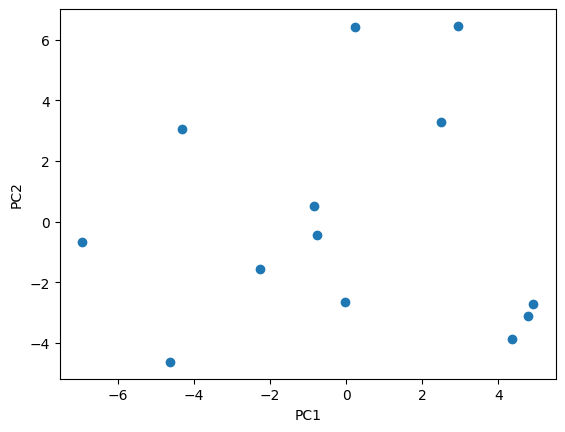

In [14]:
# Plot the first two PCs and calculate variance explained from first 4 PC's ALso calculate the overall variance captured by all PC's
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(x=X_pca[:,0], y=X_pca[:,1])
print('{} variance explained by the first four PCs.'.format(round(pca.explained_variance_ratio_[0:4].sum(),2)))
print('{} variance explained overall.'.format(round(pca.explained_variance_ratio_.sum(),2)))

In [15]:
# Is this where UMAP should go before proceeding?




In [16]:
#showing contents of the data table df_pca that only has the columns for the first 4 PC's
df_pca

,PC1,PC2,PC3,PC4
0,4.790350,-3.098232,-2.424191,-1.339439
1,-2.252942,-1.566213,-3.816638,0.608750
2,-4.618687,-4.625961,4.127308,4.942432
3,2.951292,6.447596,6.335644,1.280645
4,-6.935356,-0.680649,-1.495549,-1.896040
5,-4.319302,3.048779,2.577184,-4.905084
6,4.366898,-3.883383,2.677667,-2.316577
7,-0.847165,0.508514,-0.569861,-2.050984
8,-0.759200,-0.458844,-1.045827,1.892916
9,4.917613,-2.730382,-0.937567,-0.129576


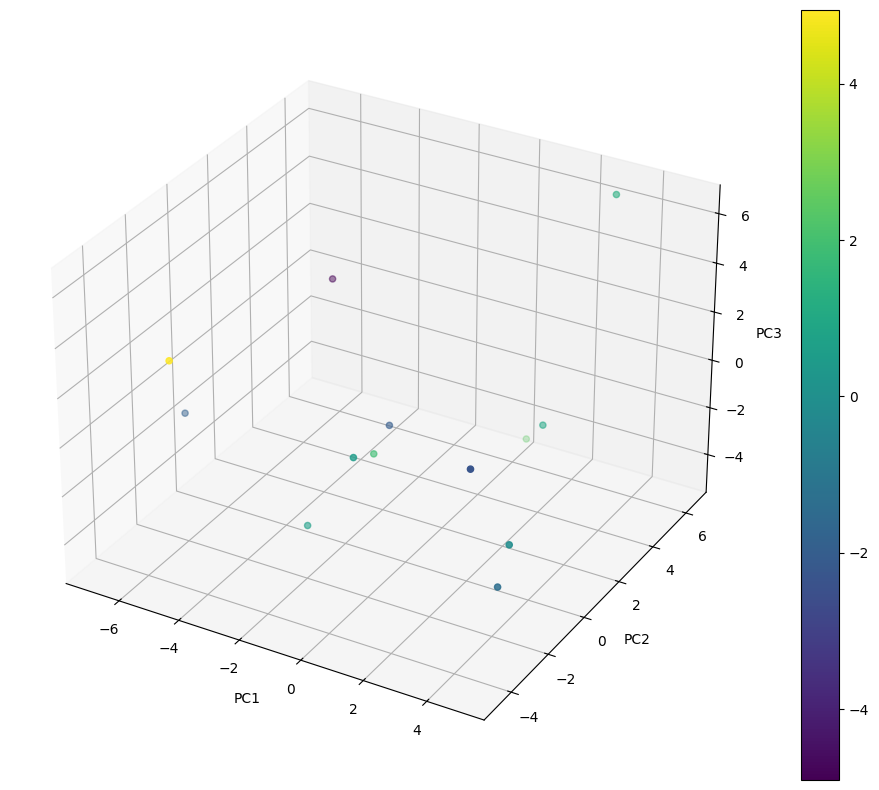

In [17]:
#plotting the first three PC's and coloring by PC4
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
PC4=df_pca['PC4']

plot=ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=PC4)
plt.colorbar(plot)


In [18]:
#list the most important features for the first four PC's and create a csv file that has this information
df_pca_importance = pd.DataFrame({'features': X.columns, 'PC1_importance': pca.components_[0,:], 
                                  'PC2_importance': pca.components_[1,:], 'PC3_importance': pca.components_[2,:], 'PC4_importance': pca.components_[3,:]})

df_pca_importance.to_csv('PCA_importance_selected_phosphines.csv', index=False)
print('PC1 importance:\n', df_pca_importance.sort_values('PC1_importance', ascending=False).head(10).drop(columns=['PC2_importance', 'PC3_importance', 'PC4_importance']))
print('PC2 importance:\n', df_pca_importance.sort_values('PC2_importance', ascending=False).head(10).drop(columns=['PC1_importance', 'PC3_importance', 'PC4_importance']))
print('PC3 importance:\n', df_pca_importance.sort_values('PC3_importance', ascending=False).head(10).drop(columns=['PC2_importance', 'PC1_importance', 'PC4_importance']))
print('PC4 importance:\n', df_pca_importance.sort_values('PC4_importance', ascending=False).head(10).drop(columns=['PC1_importance', 'PC3_importance', 'PC2_importance']))


PC1 importance:
                                    features  PC1_importance
26                       NMR_shift_C1_Boltz        0.217445
13  Buried_Sterimol_L_N1_C1_5.0(Å)_Vbur_min        0.213810
14     Buried_Sterimol_L_N1_C1_5.0(Å)_low_E        0.212198
44      Sterimol_L_N1_C1(Å)_dbstep_Vbur_min        0.206101
33        Sterimol_Bmax_N1_C1_0.0Å(Å)_Boltz        0.175951
21                NBO_LP_occupancy_N1_Boltz        0.172536
19                   NBO_LP_energy_N1_Boltz        0.167556
20                     NBO_LP_energy_N1_max        0.167512
43         Sterimol_L_N1_C1(Å)_dbstep_Boltz        0.160465
12     Buried_Sterimol_L_N1_C1_5.0(Å)_Boltz        0.156791
PC2 importance:
                                          features  PC2_importance
27                             NMR_shift_N1_Boltz        0.254266
23                         NBO_charge_C1_Vbur_min        0.227857
48                              dipole(Debye)_max        0.220853
22                            NBO_charge_C

C:\Users\R9000P\AppData\Local\Temp\ipykernel_45164\1871914602.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1000 with 3 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(plot)


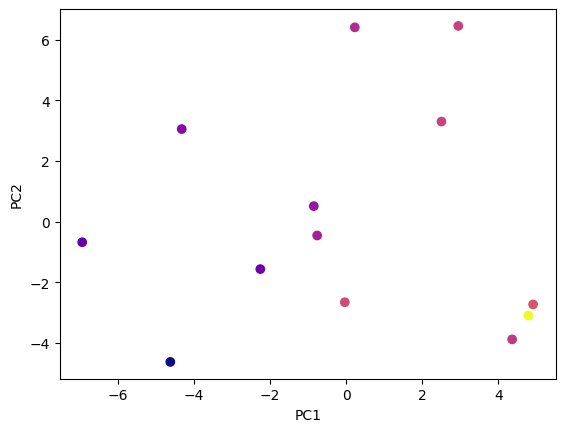

In [19]:
#plot PC1 vs PC2 vs descriptor(colored)
#uncomment for 2D comparison
descriptor=all_features_nosmiles_scaled['NMR_shift_C1_Boltz']
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(x=df_pca['PC1'], y=df_pca['PC2'], c=descriptor, cmap='plasma')
plt.colorbar(plot)

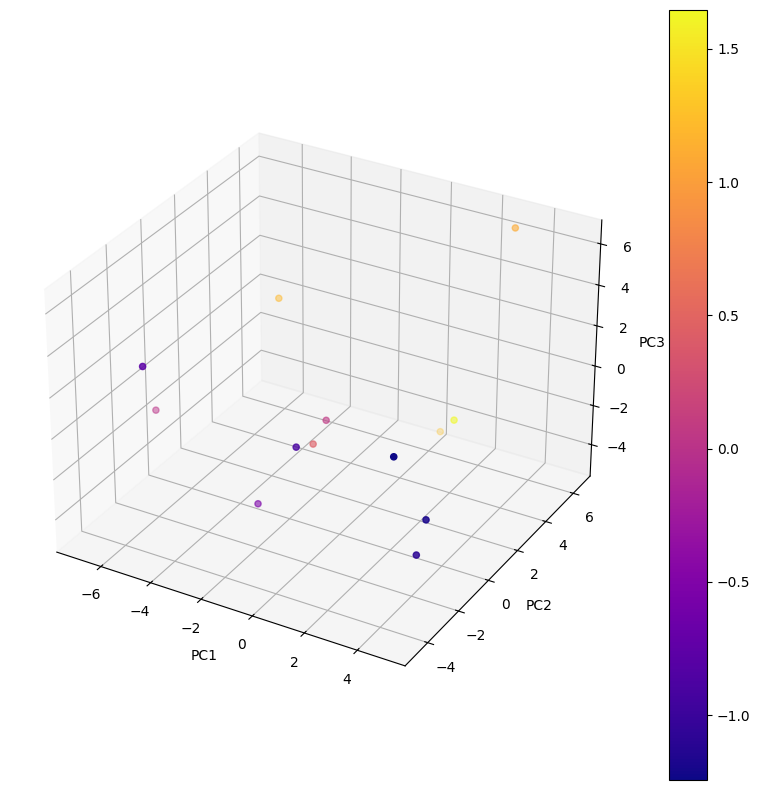

In [20]:
#plot the first three PC's and color by the most important feature for PC1
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
descriptor=all_features_nosmiles_scaled['NMR_shift_N1_Boltz']

plot=ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=descriptor, cmap='plasma')
plt.colorbar(plot)


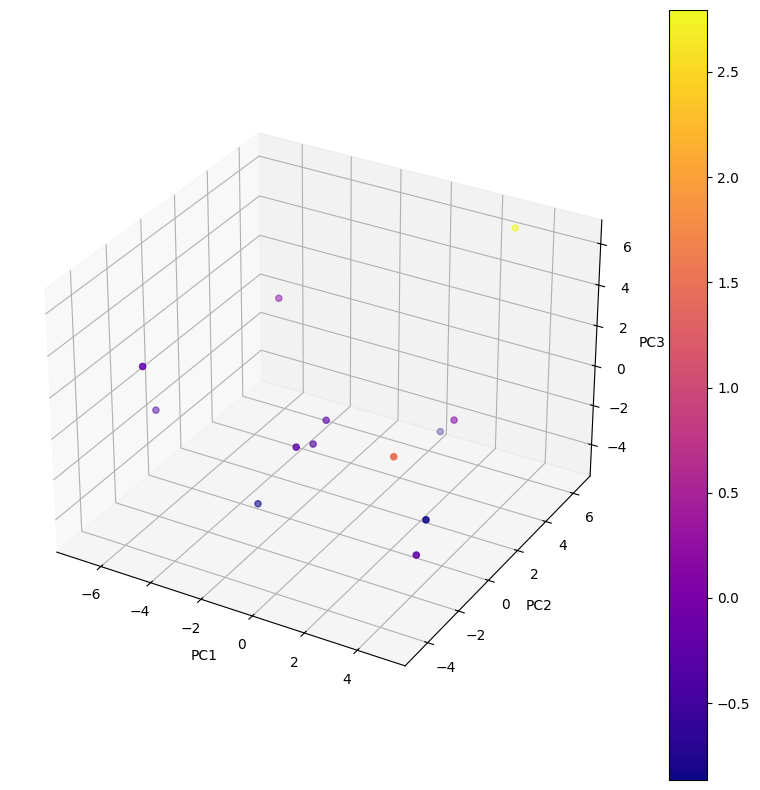

In [21]:
#plot the first three PC's and color by the most important feature for PC2
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
descriptor=all_features_nosmiles_scaled['Sterimol_B5_N1_C1(Å)_dbstep_Vbur_min']

plot=ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=descriptor, cmap='plasma')
plt.colorbar(plot)

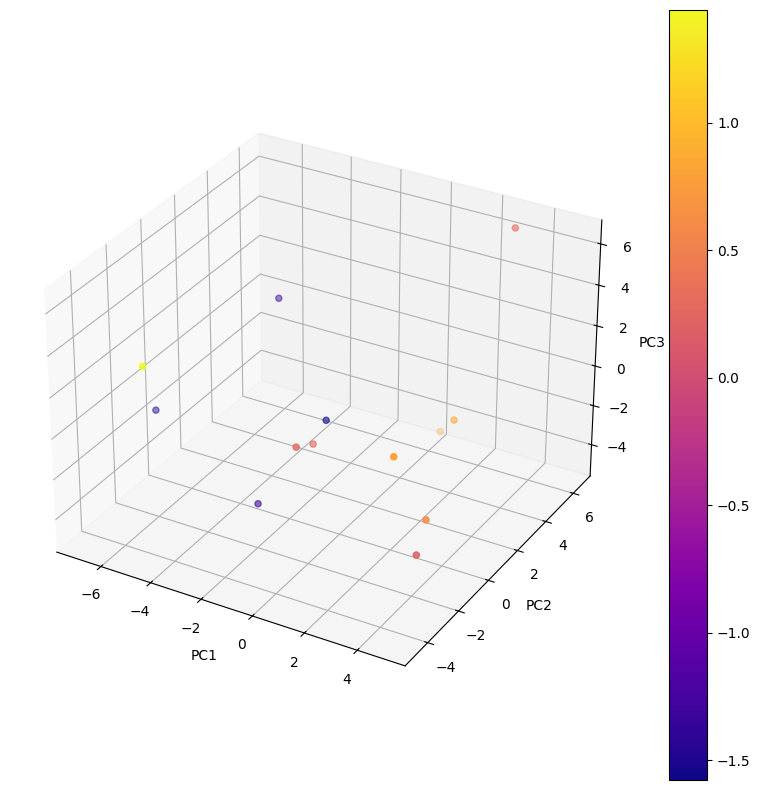

In [22]:
#plot the first three PC's and color by the most important feature for PC3
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
descriptor=all_features_nosmiles_scaled['distance_N1_C1(Å)_min']

plot=ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=descriptor, cmap='plasma')
plt.colorbar(plot)

In [23]:
use_rows = all_features_nosmiles_scaled.index # use this if no filtering is applied

# apply optional filtering here. Un/Comment as required

# for example: filter by commercial availability
#criterion1 = set(filters.loc[filters["com"] == 1].index)

# for example: only phosphines and phosphine amines / mixed C,N substitution
# pat_filter = ["pc3","pcn","pn3"]
# criterion2 = set(filters[filters["pat"].isin(pat_filter)].index)

# or: just phosphines
#criterion2 = set(filters.loc[filters["pat"] == "pc3"].index)

# when using more than 1 criterion, use set operations to combine filter results
# use_rows = sorted(criterion1)
#use_rows = sorted(criterion1 & criterion2)
                    
print(f"Keeping {len(use_rows)} compounds.")
print(use_rows)

Keeping 13 compounds.
RangeIndex(start=0, stop=13, step=1)


In [24]:
# How many clusters to generate: In our case we are generating 32 clusters
nclusters = 5

# Which feature space to use for the clustering: PCA
use_space = "PCA" 

In [25]:
# Kmeans clustering on the first four PC's. No user changes needed

find_cols = {"PCA": ["PC1","PC2","PC3"]}

use_cols = find_cols[use_space]
X_kmeans = all_features.loc[use_rows,use_cols]

kmeans = KMeans(n_clusters=nclusters, random_state=1).fit(X_kmeans)
#data_df = all_features.loc[use_rows].copy()

all_features["closest_to_center"] = 0 #creating a column to indicate whether the ligand is the one closest to the center or not
all_features["cluster"] = kmeans.labels_ #creating a column named 'cluster' that shows which cluster number the phosphine belongs to
all_features["distance_to_center"] = all_features.apply(dist_to_center, axis = 1) #creating a column 'distance_to_center' that contains the distance of each ligand from the cluster center
clustermins = []
for clusternumber in range(nclusters):
    min_to_center_idx = all_features[all_features["cluster"] == clusternumber]["distance_to_center"].idxmin()
    clustermins.append(min_to_center_idx)
    all_features.loc[min_to_center_idx,"closest_to_center"] = 1 #For the phosphines that are closest to the cluster center indicate a '1' in the column named 'closest_to_center'

clustercounts = Counter(all_features["cluster"]) #count the number of phosphines in each cluster
print("cluster: N(samples)") #print the words 'cluster:N(samples)'
for i in sorted(clustercounts.keys()):
    print(f"{i}: {clustercounts[i]}") #print the cluster number and the number of ligands in each cluster

cluster: N(samples)
0: 2
1: 3
2: 2
3: 5
4: 1


In [26]:
#display the all features data frame to ensure that the columns created from KMeans clustering i.e. cluster, closest_to_center and distance_to_center are added to this table
all_features.to_csv('all_features.csv', index=True)
all_features

,id,smiles,%Vbur_C1_2.0Å_Boltz,%Vbur_C1_2.0Å_Vbur_min,%Vbur_C1_2.0Å_low_E,%Vbur_C1_2.0Å_max,%Vbur_C1_2.0Å_min,%Vbur_C1_2.5Å_Boltz,%Vbur_C1_2.5Å_Vbur_min,%Vbur_C1_2.5Å_low_E,...,ω_low_E,ω_max,ω_min,PC1,PC2,PC3,PC4,closest_to_center,cluster,distance_to_center
0,pyrd1,BrC1=C2C(OCCC2)=CN=C1,90.705708,90.705708,90.705708,90.705708,90.705708,74.778617,74.778617,74.778617,...,0.03849,0.03849,0.03849,4.790350,-3.098232,-2.424191,-1.339439,0,1,2.202775
1,pyrd2,ClC1=NC=CC=C1C,95.180139,95.180139,95.180139,95.180139,95.180139,85.671962,85.671962,85.671962,...,0.04165,0.04165,0.04165,-2.252942,-1.566213,-3.816638,0.608750,1,2,2.650315
2,pyrd3,BrC1=CC(C)=NC=C1,95.716038,95.716038,95.716038,95.716038,95.716038,85.748470,85.748470,85.748470,...,0.04468,0.04468,0.04468,-4.618687,-4.625961,4.127308,4.942432,0,0,3.917721
3,pyrd4,O=C(NC1=NC=CC(C2CC2)=C1)C3=CC=C(B4OC(C)(C)C(C)...,94.741043,94.731405,94.731405,94.976756,94.731405,84.651442,84.703412,84.703412,...,0.04981,0.04981,0.04817,2.951292,6.447596,6.335644,1.280645,1,4,0.000000
4,pyrd5,ClC1=NC(C(F)(F)F)=CC(C)=C1,95.276989,95.276989,95.276989,95.276989,95.276989,85.032231,85.032231,85.032231,...,0.05459,0.05459,0.05459,-6.935356,-0.680649,-1.495549,-1.896040,0,2,2.650315
5,pyrd6,BrC1=CC(C)=CC(NC(OC(C)(C)C)=O)=N1,95.147784,94.957386,95.154313,95.154313,94.724948,85.525035,85.614989,85.540109,...,0.03788,0.04167,0.03788,-4.319302,3.048779,2.577184,-4.905084,1,0,3.917721
6,pyrd7,FC(F)(C1=CC(C(F)(F)F)=CC(C2=CN=CC(C)=C2)=C1)F,90.977815,91.002712,91.002712,91.002712,90.951059,75.694937,75.712983,75.712983,...,0.05861,0.05870,0.05861,4.366898,-3.883383,2.677667,-2.316577,0,1,2.994312
7,pyrd8,BrC1=NC(C2=CN=CS2)=CC(C)=C1,95.543657,95.858084,95.858084,95.858084,95.228564,86.068125,86.637257,86.637257,...,0.05610,0.05622,0.05610,-0.847165,0.508514,-0.569861,-2.050984,1,3,1.633790
8,pyrd9,CC1=NC(Cl)=CC2=C1C=NN2,95.699897,95.699897,95.699897,95.699897,95.699897,85.989387,85.989387,85.989387,...,0.04736,0.04736,0.04736,-0.759200,-0.458844,-1.045827,1.892916,0,3,2.147554
9,pyrd10,BrCCCC1=CN=CC=C1,90.734536,91.160899,90.902634,92.252066,90.625000,74.209673,77.646829,76.258302,...,0.03981,0.04286,0.03604,4.917613,-2.730382,-0.937567,-0.129576,1,1,0.900841


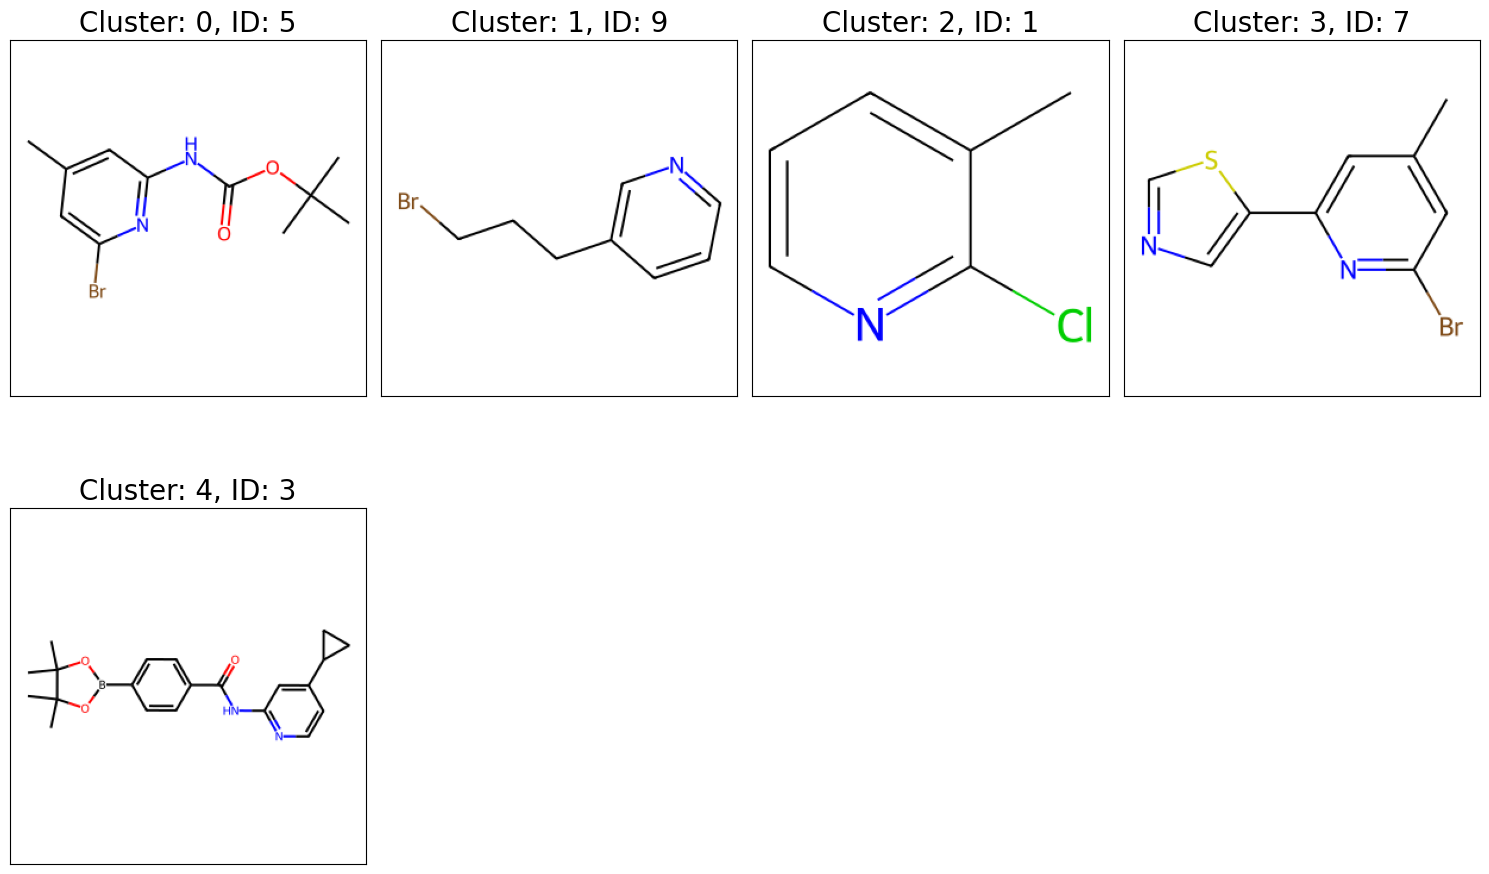

In [27]:
#display the structure of the ligand that is closest to the cluster center for each cluster. Print the cluster number and the ligand ID
molobs = [Chem.MolFromSmiles(i) for i in all_features.loc[clustermins]["smiles"]]
molobs_img = [Chem.Draw.MolToImage(i) for i in molobs]
legends = [f"Cluster: {k}, ID: {v}" for k,v in enumerate(clustermins)]
img_src = Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=4,
                                  legends = legends)
Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=4,
                                  legends = legends)
draw_grid_image(molobs_img, legends, 4, "closest_to_center", None)

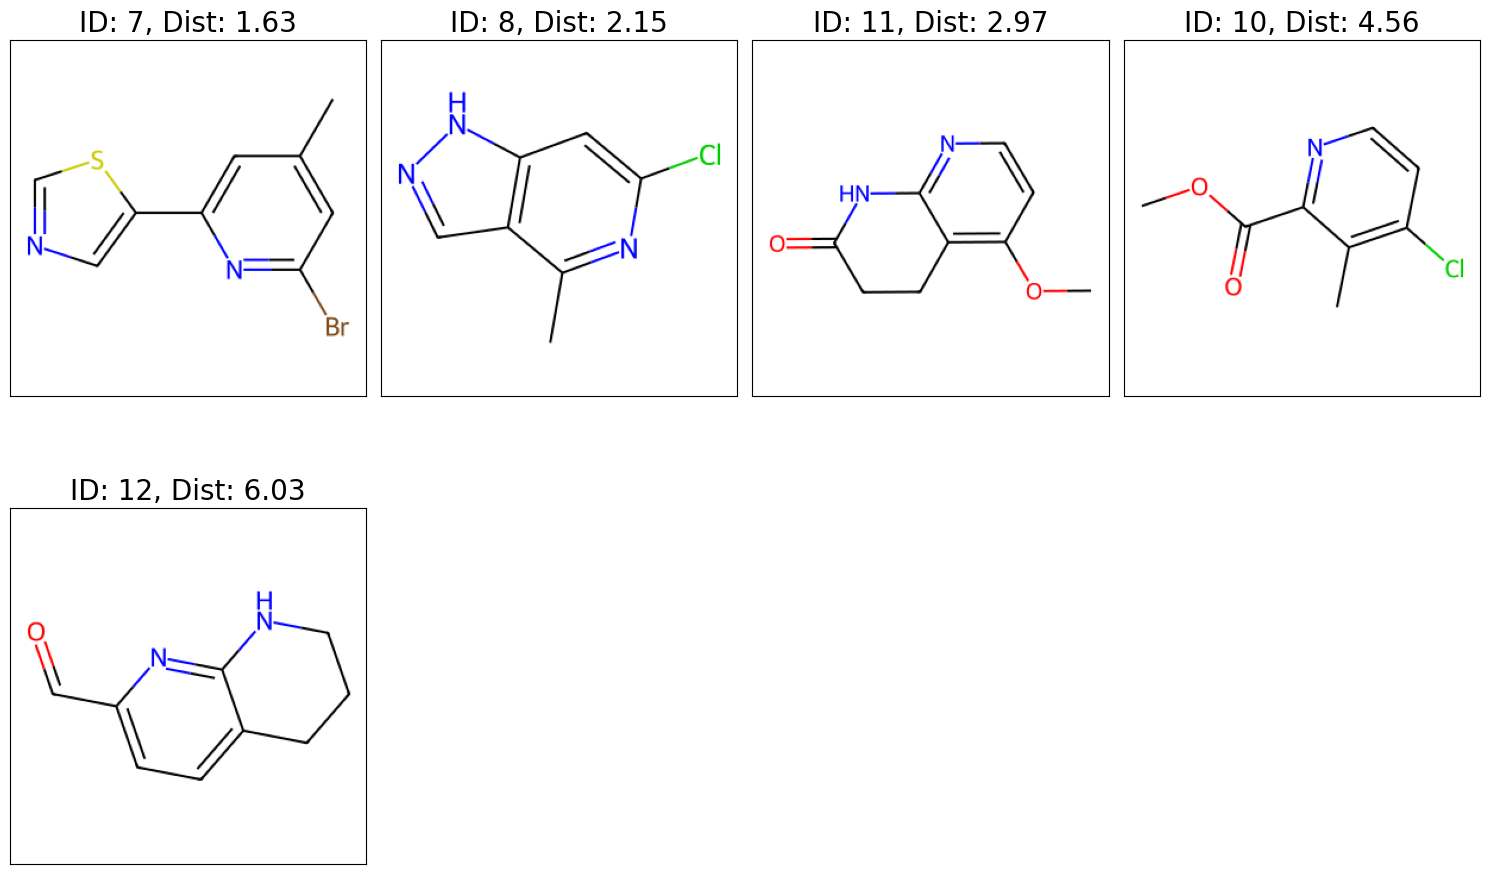

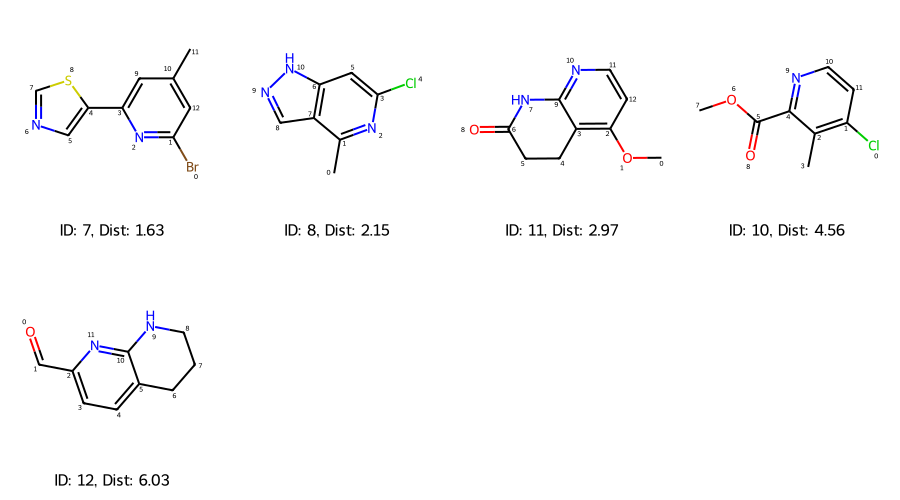

In [28]:
show_n_mols = 50  # Show up to N molecules nearest to the cluster center
cluster_select = 3 # which cluster to inspect

#####

def generate_molimg(show_n_mols,clusters_select):
    show_n_mols = int(show_n_mols)
    clustermin_idx = clustermins[clusters_select]
    
    sorted_mols = all_features.loc[all_features["cluster"] == clusters_select].sort_values(by="distance_to_center")
    showno = min(show_n_mols,len(sorted_mols))
    show_idxs = sorted_mols.iloc[:showno].index
    molobs = [Chem.MolFromSmiles(i) for i in sorted_mols.loc[show_idxs,"smiles"]]
    molobs_img = [Chem.Draw.MolToImage(i) for i in molobs]
    legends = [f"ID: {i}, Dist: {all_features.loc[i,'distance_to_center']:.2f}" for i in show_idxs]
    img_src = Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=4,
                                  legends = legends)
    draw_grid_image(molobs_img, legends, 4, "closest_to_center", None)
    
    return(img_src)

generate_molimg(show_n_mols,cluster_select)

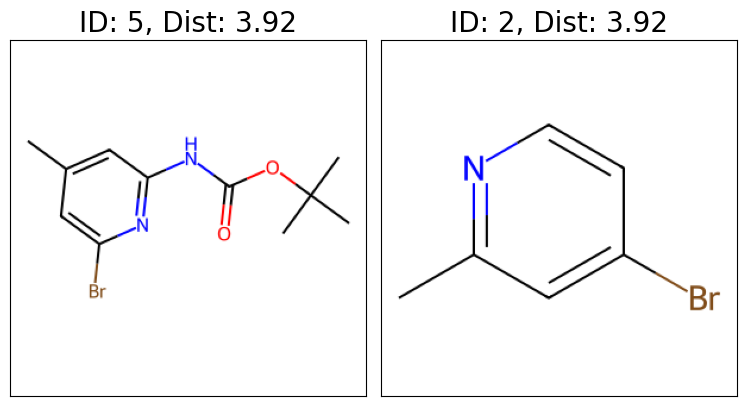

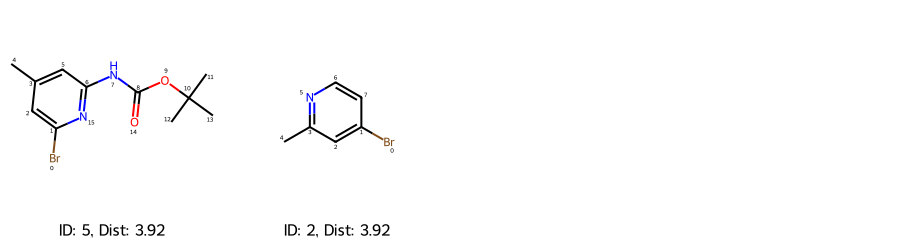

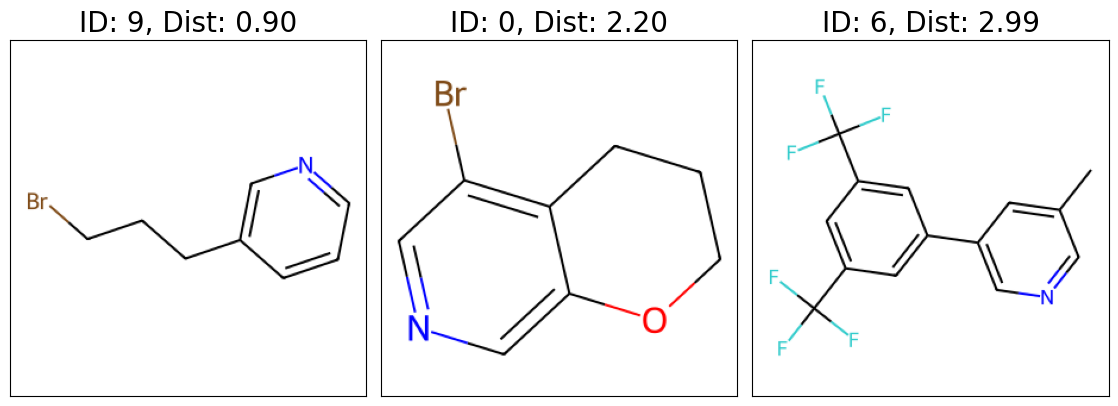

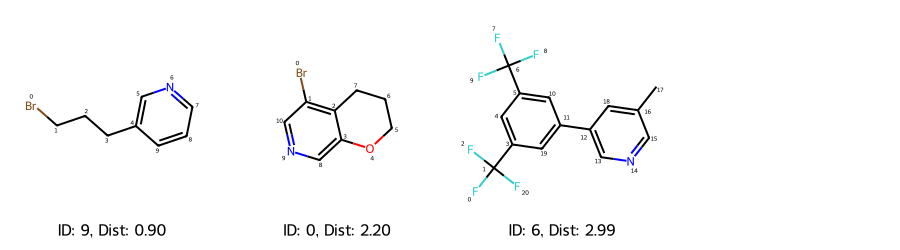

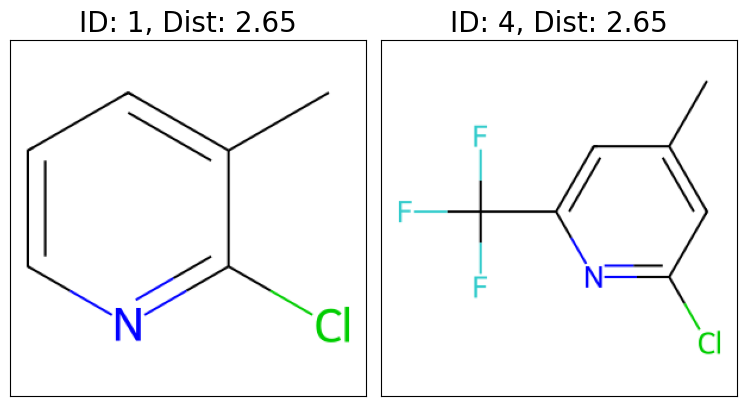

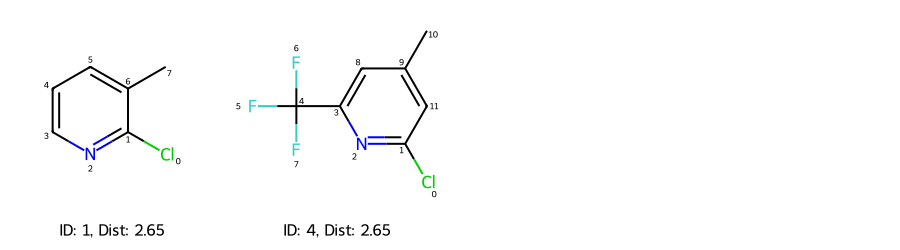

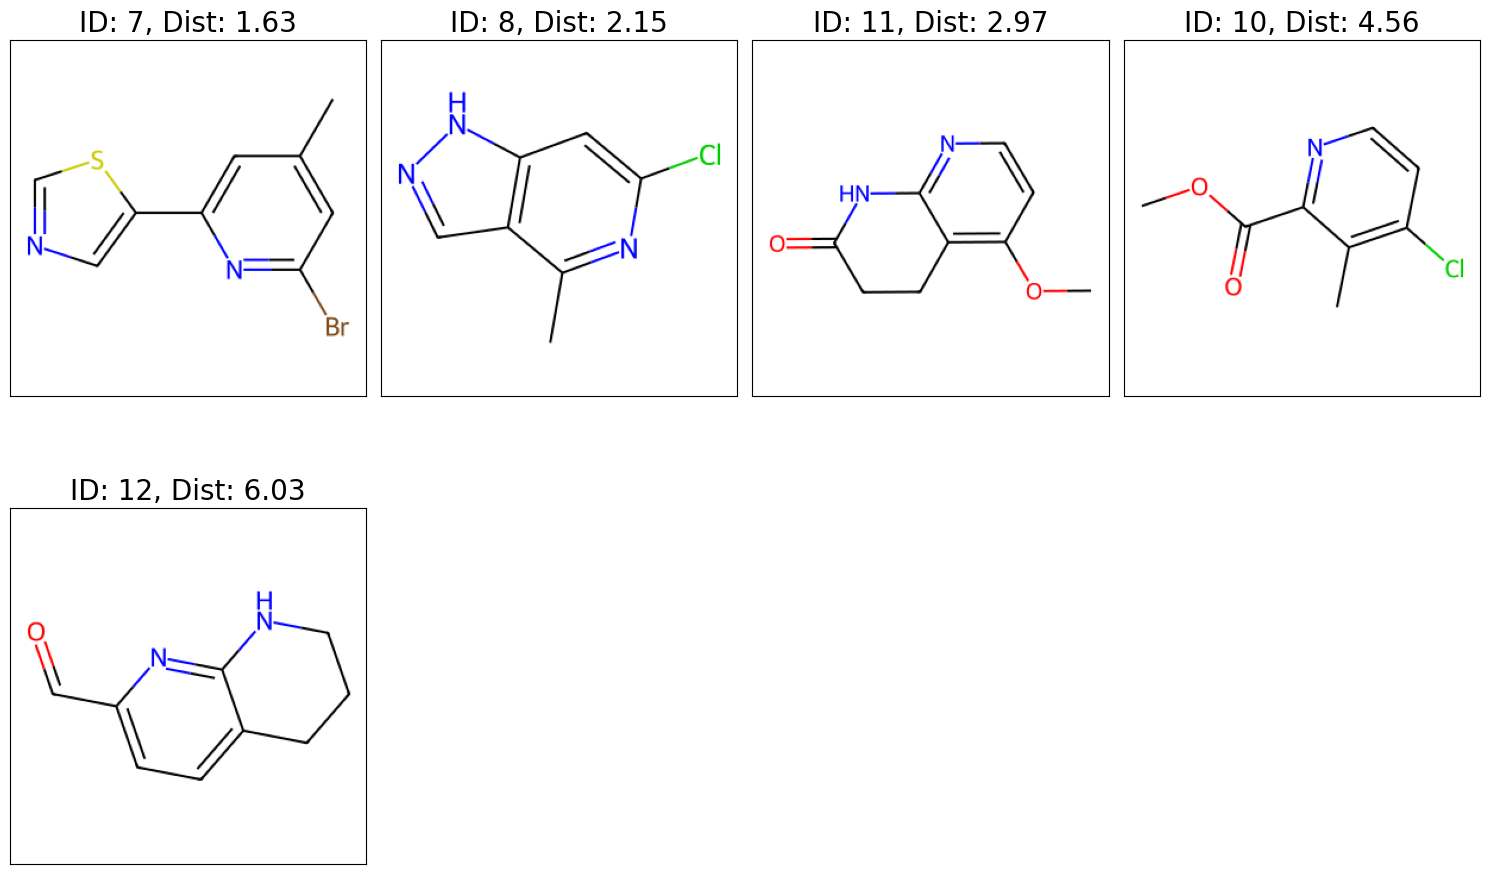

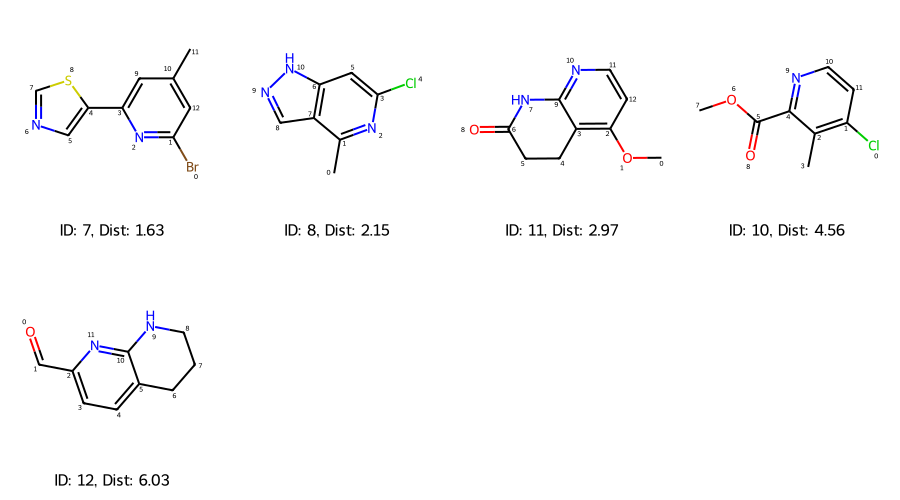

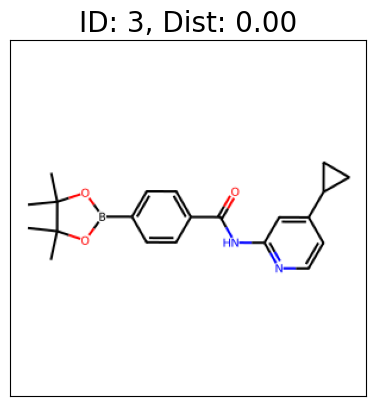

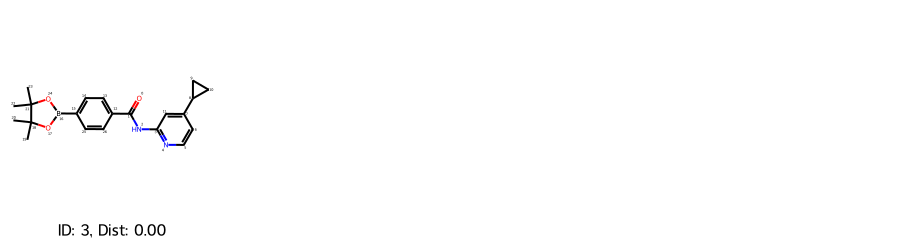

In [29]:
for i in range(nclusters):
    display(generate_molimg(show_n_mols,i))

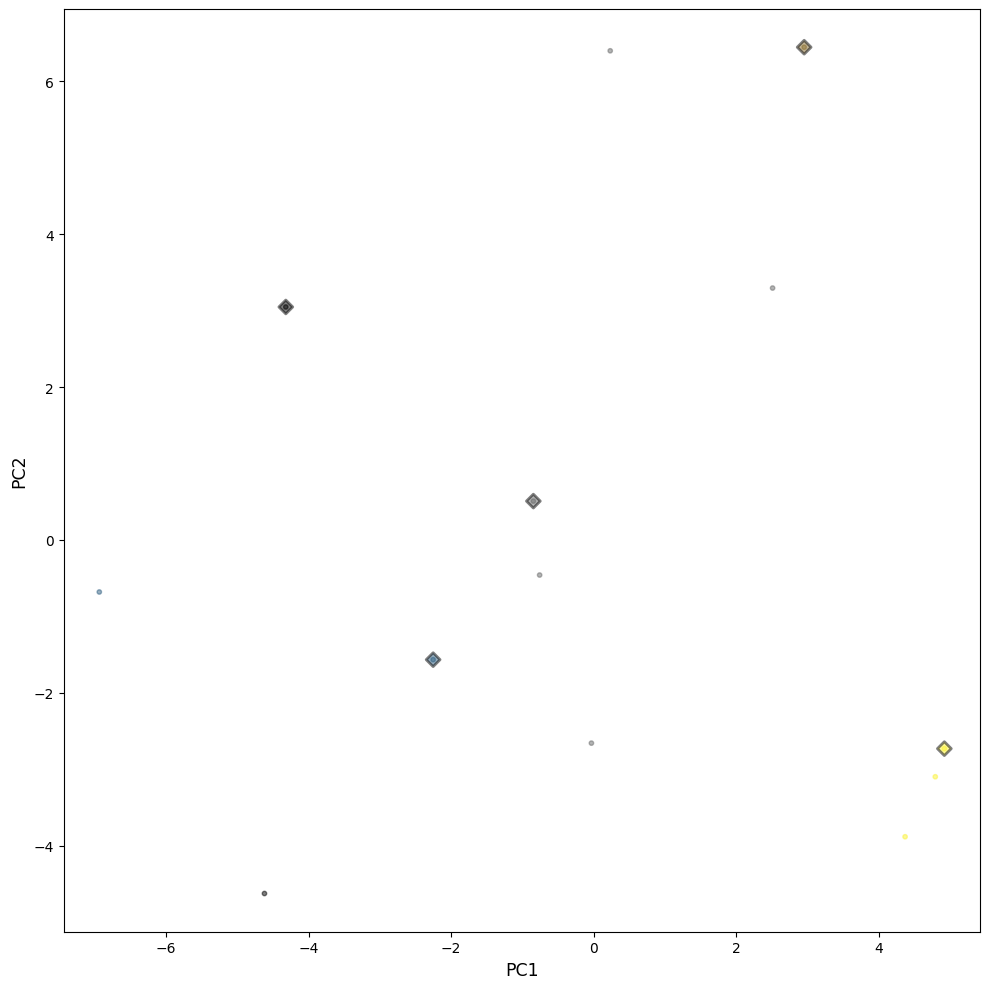

In [30]:
# plot the chemical space using the first two PC's. show the 32 clusters using 32 different colors. Show the ligands closest to the cluster centers with the larger diamonds

f_ind_1,f_ind_2 = use_cols[:2]

x_min, x_max = X_kmeans[f_ind_1].min() - .5, X_kmeans[f_ind_1].max() + .5
y_min, y_max = X_kmeans[f_ind_2].min() - .5, X_kmeans[f_ind_2].max() + .5

plt.figure(figsize=(10,10))
extent = [x_min,x_max,y_min,y_max]

mapping_cl = kmeans.labels_

cMap_cl = ListedColormap(colors32) 

plt.scatter(X_kmeans[f_ind_1], X_kmeans[f_ind_2],c=mapping_cl,cmap=cMap_cl,alpha=0.5,marker="o",s=10) 

plt.scatter(X_kmeans.loc[clustermins,f_ind_1], X_kmeans.loc[clustermins,f_ind_2],
        c=range(nclusters), cmap=cMap_cl,
        alpha=0.5, marker="D", s=50, edgecolor="black", linewidth=2)#show ligands closest to the cluster center with diamond shape

plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.xlabel(f_ind_1,fontsize=12.5)
plt.ylabel(f_ind_2,fontsize=12.5)
plt.locator_params(axis='y', nbins=8)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.tight_layout()
plt.show()  

In [31]:
#Although we chose 11 clusters above there is a way for finding optimal number of clusters using change in distortion, change in inertia or change in silhouette scores 
# the code in this cell is calculating the intertia, distortion and silhouette score for even numbered clusters ranging between 1 and 50
X = df_pca
metric = 'euclidean'
k_clusters = []
distortions = []
inertias = []
s_scores = []
K = range(2, min(all_features_nosmiles_scaled.shape) - 1)
  
for k in K:
        k_clusters.append(k)
        k_means = KMeans(n_clusters=k).fit(X)
        k_means.fit(X)
        labels = k_means.labels_
        
        #Calculate distortion, intertia, silhouette scores every even numbered cluster number (k) 
        distortions.append(sum(np.min(cdist(X, k_means.cluster_centers_,metric), axis=1)) / X.shape[0])
        inertias.append(k_means.inertia_)
        s_scores.append(metrics.silhouette_score(X, labels, metric=metric))

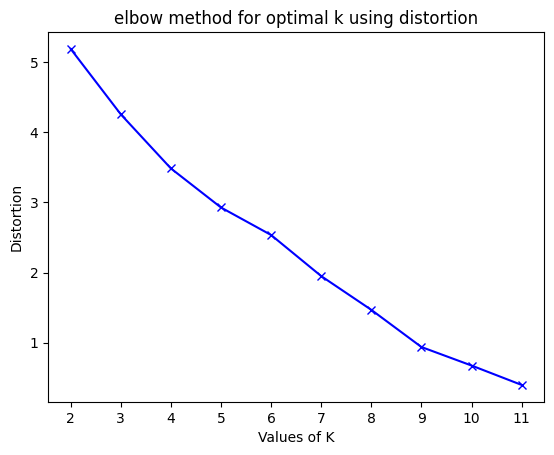

In [32]:
#plotting the change in distortion versus the number of clusters
plt.plot(k_clusters, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
# xticks should be in increments of 1
plt.xticks(np.arange(min(k_clusters), max(k_clusters)+1, 1.0))
plt.title('elbow method for optimal k using distortion')
plt.show()

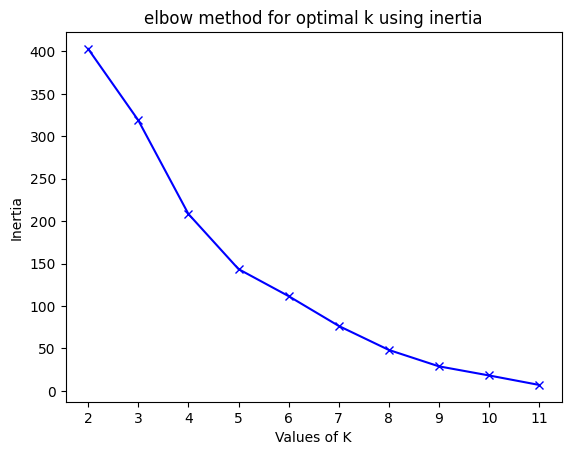

In [33]:
#plotting the change in inertia versus the number of clusters
plt.plot(k_clusters, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
# xticks should be in increments of 1
plt.xticks(np.arange(min(k_clusters), max(k_clusters)+1, 1.0))
plt.title('elbow method for optimal k using inertia')
plt.show()

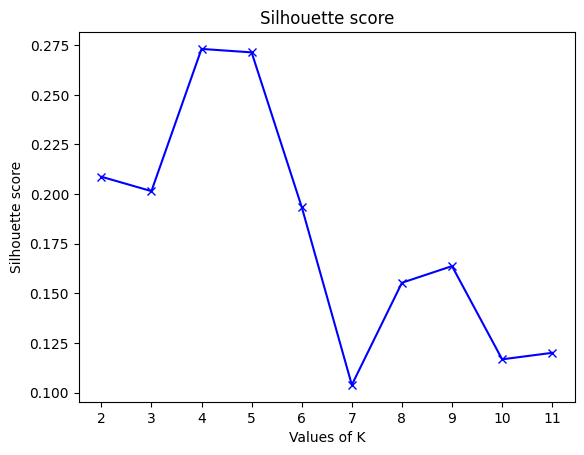

In [34]:
#plotting the change in Silhouette scores versus the number of clusters
plt.plot(k_clusters, s_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
# xticks should be in increments of 1
plt.xticks(np.arange(min(k_clusters), max(k_clusters)+1, 1.0))
plt.title('Silhouette score')
plt.show()

In [35]:
#rather than using clustering based approach randomly sampling 11 ligands from the 319 possibilities and storing the information on these randomly selected ligands in the data_frame named 'all_features_elements'
#all_features_elements = all_features.sample(n=32, random_state=42)
all_features_elements = all_features.sample(n=3)
all_features_elements
all_features_elements['random_selection'] = 'True'
all_features_elements

,id,smiles,%Vbur_C1_2.0Å_Boltz,%Vbur_C1_2.0Å_Vbur_min,%Vbur_C1_2.0Å_low_E,%Vbur_C1_2.0Å_max,%Vbur_C1_2.0Å_min,%Vbur_C1_2.5Å_Boltz,%Vbur_C1_2.5Å_Vbur_min,%Vbur_C1_2.5Å_low_E,...,ω_max,ω_min,PC1,PC2,PC3,PC4,closest_to_center,cluster,distance_to_center,random_selection
8,pyrd9,CC1=NC(Cl)=CC2=C1C=NN2,95.699897,95.699897,95.699897,95.699897,95.699897,85.989387,85.989387,85.989387,...,0.04736,0.04736,-0.759200,-0.458844,-1.045827,1.892916,0,3,2.147554,True
7,pyrd8,BrC1=NC(C2=CN=CS2)=CC(C)=C1,95.543657,95.858084,95.858084,95.858084,95.228564,86.068125,86.637257,86.637257,...,0.05622,0.05610,-0.847165,0.508514,-0.569861,-2.050984,1,3,1.633790,True
5,pyrd6,BrC1=CC(C)=CC(NC(OC(C)(C)C)=O)=N1,95.147784,94.957386,95.154313,95.154313,94.724948,85.525035,85.614989,85.540109,...,0.04167,0.03788,-4.319302,3.048779,2.577184,-4.905084,1,0,3.917721,True


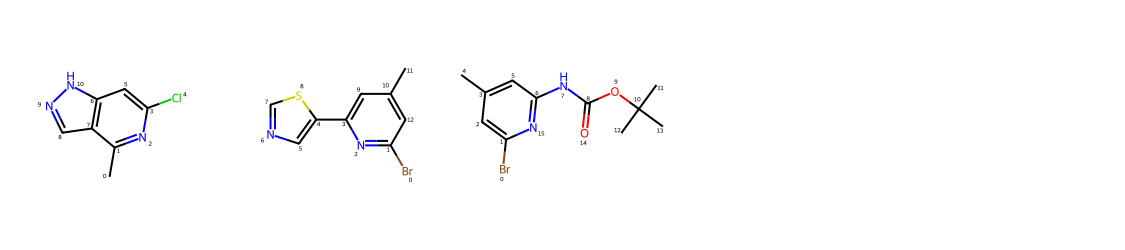

In [36]:
#show ligands arising from random selection
molobs1 = [Chem.MolFromSmiles(i) for i in all_features_elements["smiles"]]
img_src = Draw.MolsToGridImage(molobs1, subImgSize=(225,250), molsPerRow=4)
Draw.MolsToGridImage(molobs1, subImgSize=(225,250), molsPerRow=5)

In [37]:
#adding a column named 'random selection' to all features data table that shows 'True' for randomly selected phosphines
all_features=all_features.merge(all_features_elements[['random_selection','id']], on = 'id', how = 'left')
all_features

,id,smiles,%Vbur_C1_2.0Å_Boltz,%Vbur_C1_2.0Å_Vbur_min,%Vbur_C1_2.0Å_low_E,%Vbur_C1_2.0Å_max,%Vbur_C1_2.0Å_min,%Vbur_C1_2.5Å_Boltz,%Vbur_C1_2.5Å_Vbur_min,%Vbur_C1_2.5Å_low_E,...,ω_max,ω_min,PC1,PC2,PC3,PC4,closest_to_center,cluster,distance_to_center,random_selection
0,pyrd1,BrC1=C2C(OCCC2)=CN=C1,90.705708,90.705708,90.705708,90.705708,90.705708,74.778617,74.778617,74.778617,...,0.03849,0.03849,4.790350,-3.098232,-2.424191,-1.339439,0,1,2.202775,NaN
1,pyrd2,ClC1=NC=CC=C1C,95.180139,95.180139,95.180139,95.180139,95.180139,85.671962,85.671962,85.671962,...,0.04165,0.04165,-2.252942,-1.566213,-3.816638,0.608750,1,2,2.650315,NaN
2,pyrd3,BrC1=CC(C)=NC=C1,95.716038,95.716038,95.716038,95.716038,95.716038,85.748470,85.748470,85.748470,...,0.04468,0.04468,-4.618687,-4.625961,4.127308,4.942432,0,0,3.917721,NaN
3,pyrd4,O=C(NC1=NC=CC(C2CC2)=C1)C3=CC=C(B4OC(C)(C)C(C)...,94.741043,94.731405,94.731405,94.976756,94.731405,84.651442,84.703412,84.703412,...,0.04981,0.04817,2.951292,6.447596,6.335644,1.280645,1,4,0.000000,NaN
4,pyrd5,ClC1=NC(C(F)(F)F)=CC(C)=C1,95.276989,95.276989,95.276989,95.276989,95.276989,85.032231,85.032231,85.032231,...,0.05459,0.05459,-6.935356,-0.680649,-1.495549,-1.896040,0,2,2.650315,NaN
5,pyrd6,BrC1=CC(C)=CC(NC(OC(C)(C)C)=O)=N1,95.147784,94.957386,95.154313,95.154313,94.724948,85.525035,85.614989,85.540109,...,0.04167,0.03788,-4.319302,3.048779,2.577184,-4.905084,1,0,3.917721,True
6,pyrd7,FC(F)(C1=CC(C(F)(F)F)=CC(C2=CN=CC(C)=C2)=C1)F,90.977815,91.002712,91.002712,91.002712,90.951059,75.694937,75.712983,75.712983,...,0.05870,0.05861,4.366898,-3.883383,2.677667,-2.316577,0,1,2.994312,NaN
7,pyrd8,BrC1=NC(C2=CN=CS2)=CC(C)=C1,95.543657,95.858084,95.858084,95.858084,95.228564,86.068125,86.637257,86.637257,...,0.05622,0.05610,-0.847165,0.508514,-0.569861,-2.050984,1,3,1.633790,True
8,pyrd9,CC1=NC(Cl)=CC2=C1C=NN2,95.699897,95.699897,95.699897,95.699897,95.699897,85.989387,85.989387,85.989387,...,0.04736,0.04736,-0.759200,-0.458844,-1.045827,1.892916,0,3,2.147554,True
9,pyrd10,BrCCCC1=CN=CC=C1,90.734536,91.160899,90.902634,92.252066,90.625000,74.209673,77.646829,76.258302,...,0.04286,0.03604,4.917613,-2.730382,-0.937567,-0.129576,1,1,0.900841,NaN


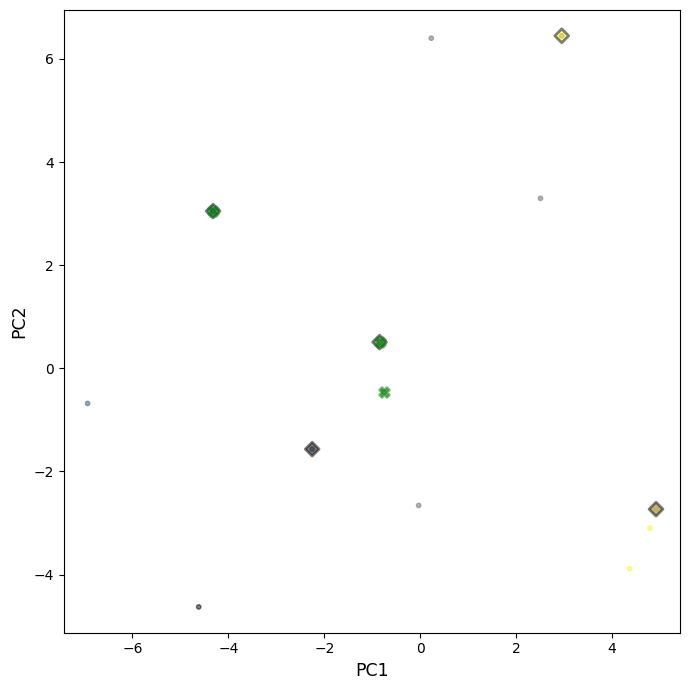

In [38]:
# plot the chemical space using the first two PC's. show the 32 clusters using 32 different colors. Show the ligands closest to the cluster centers with the larger diamonds
# using the black crosses to show ligands that were randomly selected
plt.figure(figsize=(7,7))

cMap_cl = ListedColormap(colors32) 

plt.scatter(all_features['PC1'], all_features['PC2'],c=all_features['cluster'],cmap=cMap_cl,alpha=0.5,marker="o",s=10) 

plt.scatter(all_features.loc[all_features['closest_to_center']==1,['PC1']], all_features.loc[all_features['closest_to_center']==1,['PC2']],
        c=range(nclusters), cmap=cMap_cl,
        alpha=0.5, marker="D", s=50, edgecolor="black", linewidth=2)
plt.scatter(all_features.loc[all_features['random_selection']=='True',['PC1']], all_features.loc[all_features['random_selection']=='True',['PC2']],
        c='green',
        alpha=0.5, marker="X", s=50, edgecolor="green", linewidth=2)

plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.xlabel('PC1',fontsize=12.5)
plt.ylabel('PC2',fontsize=12.5)
plt.locator_params(axis='y', nbins=8)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.tight_layout()
plt.show()  


In [39]:

#plt.hist(all_features['cluster'])

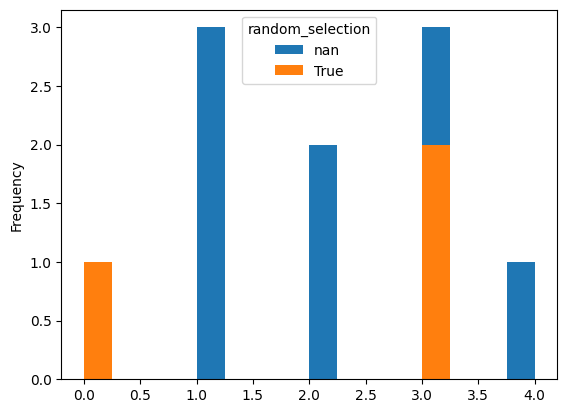

In [40]:
#shows how the randomly selected ligands are distributed across the 16 clusters. orange indicates the ligands that were randomly selected
all_features.pivot(columns='random_selection', values='cluster').plot.hist(bins=16)
plt.show()